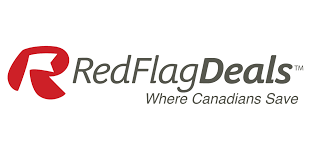

[RedFlagDeals](https://forums.redflagdeals.com/hot-deals-f9/) is a forum where users can post sales or deals that they have come accross. The first part of this project is focused on scraping relevant information from the "All Hot Deals" section that includes all product categories. In the second and third part I will clean and visualize the data to extract and summarize useful information.  

|Column name|Description|
|---|---|
|'title'| Title of post|
|'votes'| Sum of up-, and down-votes|
|'source'| Name of retailer offering the sale|
|'creation_date'| Date of initial post|
|'last_reply'| Date of most recent reply|
|'author'| User name of post author|
|'replies'| Number of replies|
|'views'| Number of views|
|'price'| Price of product on sale|
|'saving'| Associated saving|
|'expiry'| Expiry date of sale|
|'url'| Link to deal|

In [1]:
# Packages
import requests # Scraping
from bs4 import BeautifulSoup # HTML parsing
import pandas as pd
import numpy as np
import datetime

## I. Retrieving data from the "All Hot Deals" sub-forum

URL format for different pages: `root-url/page#/`

In [11]:
# Initialize global variables used to iterate over web-pages.
current_page = "" # page number; used to format root URL
total_pages = 1 # endpoint for iteration; set through get_posts()
root_url = "https://forums.redflagdeals.com/hot-deals-f9/" # base url for "All Hot Deals" sub-forum

# URL base to generate links to specific posts
base_url = "https://forums.redflagdeals.com"

# Dataframe to store scraped data
table = pd.DataFrame(columns=
    ['title',
    'votes',
    'source',
    'creation_date',
    'last_reply',
    'author',
    'replies',
    'views',
    'price',
    'saving',
    'expiry',
    'url'])

In [12]:
def get_posts(page: str) -> list:
    """
    Returns list of parsed object containing all post elements from
    the current 'page' and sets gloabl variable 'total_pages'
    
    Args:
    page - url string of current page
    
    Returns:
    topics - all parsed elements of class 'row topic'
    total_pages - sets global variable
    """
    
    # Initalize list of posts on page class="row topic"
    posts = []
    
    # Get entire page content
    response = requests.get(page)
    content = response.content
    
    # Find total number of pages and set global variable accordingly
    # Format of text: " {current page #} of {total page #} "
    # Need to strip white space and extract total page #
    parser = BeautifulSoup(content, 'html.parser')
    pages = parser.select(".pagination_menu_trigger")[0].text.strip().split("of ")[1]
    global total_pages
    total_pages = int(pages)
    
    # Find and return topics
    topics = parser.find_all("li", class_="row topic")
    return topics

In [13]:
def get_additional_info(post: str) -> dict:
    """
    Extracts and returns additional information from a RedFlagDeal post:
    url-link to the deal, the price of the product, the discount saving, 
    the expiry date and the parent/thread categories of the product. Returns 
    NaN values for objects that are not found.
    
    Args:
    post - url string linking to a specific post
    
    Returns:
    additional_info - dictionary containing additional information about the post.
    """
    
    # Additional information found in post
    additional_info = {}
    
    # Get content of post
    response = requests.get(post)
    content = response.content
    parser = BeautifulSoup(content, 'html.parser')
    
    # Thread-header with information on parent and thread category
    try: # parent category
        parent_category = parser.select(".thread_parent_category")[0].text
        additional_info['Parent:'] = parent_category
    except: additional_info['Parent:'] = np.nan # NaN if category not found
    try: # thread category
        thread_category = parser.select(".thread_category")[0].text
        additional_info['Thread:'] = thread_category
    except: additional_info['Thread:'] = np.nan # NaN if category not found
    
    
    # Offer-summary field: may contain deal link, price, saving, and retailer
    summary = parser.select(".post_offer_fields") # format example: "Price:\n$200\nSaving:\n70%"
    try:
        summary_list = summary[0].text.split("\n") 
    except: summary_list = []
        
    # Go through summary elements and save relevant information
    for i in range(1, (len(summary_list) -1), 2): # index 0 is empty string
        current_element = summary_list[i] # content of current list element
        next_element = summary_list[i+1] # next list element
        
        # Price, saving, and expiry date information contained in the next list element will be saved
        if current_element.startswith("Price") or current_element.startswith("Saving") or current_element.startswith("Expiry"):
            additional_info[current_element]  = next_element # next elements corrsponds to content
            
    # URL to link. Full link not available through .text
    try: 
        url = str(summary[0]).split('href="')[1].split('"')[0] # select link between href=" and "
        additional_info['Link:'] = url
    except: additional_info['Link:'] = np.nan
        
    
    # If any of the elements is not found in the summary-field add None value to dictionary 
    if "Price:" not in additional_info:
        additional_info['Price:'] = np.nan
        
    if "Savings:" not in additional_info:
        additional_info['Savings:'] = np.nan
        
    if "Expiry:" not in additional_info:
        additional_info['Expiry:'] = np.nan
    
    return additional_info # Return dictionary containing with information on price, saving and expiry  

In [14]:
def fill_table(posts: list) -> None:
    '''
    Extracts parsed data from current page and appends to the global table variable.
    
    Args:
    posts - list of parsed post elements obtained through get_posts()
    '''
    
    # Temporary DataFrame object that will be appended to the global 'table' variable
    tmp_table = pd.DataFrame() 
    
    # Initializing columns for tmp_table
    title_col = pd.Series()
    source_col = pd.Series()
    url_col = pd.Series()
    votes_col = pd.Series()
    replies_col = pd.Series()
    views_col = pd.Series()
    creation_date_col = pd.Series()
    last_reply_col = pd.Series()
    author_col = pd.Series()
    price_col = pd.Series()
    saving_col = pd.Series()
    expiry_col = pd.Series()
    parent_col = pd.Series()
    thread_col = pd.Series()
    

    # Iterate through post elements on current page and extract data for table
    for post in posts:
        
        # Retailer corresponding to deal
        try: 
            source = post.select(".topictitle_retailer")[0].text.split("\n")[0] # split and remove line-break characters
            source_series = pd.Series(source) # transforming into Series object allows use of .append method
        except: source_series = pd.Series(np.nan)
        source_col = source_col.append(source_series, ignore_index=True)

        # Number of votes
        try: 
            votes = post.select(".post_voting")[0].text.split("\n")[1] 
            votes_series = pd.Series(votes) 
        except: votes_series = pd.Series(0)
        votes_col = votes_col.append(votes_series, ignore_index=True)
            
        # Title 
        try:
            topic = post.select(".topic_title_link") 
            title = topic[0].text.split('\n')[1] 
            title_series = pd.Series(title)
        except: title_series = pd.Series(np.nan)
        title_col = title_col.append(title_series, ignore_index=True)

        # Date of initial posting
        try: 
            creation = post.select(".first-post-time")[0].text.split("\n")[0]
            creation_series = pd.Series(creation)
        except: creation_series = pd.Series(np.nan)
        creation_date_col = creation_date_col.append(creation_series, ignore_index=True) 
        
        # Date of most recent replie
        try: 
            last_replie = post.select(".last-post-time")[0].text.split("\n")[0]
            last_replie_series = pd.Series(last_replie)
        except: last_replie_series = pd.Series(np.nan)
        last_reply_col = last_reply_col.append(last_replie_series, ignore_index=True) 
        
        # Author user-name
        try:
            author = post.select(".thread_meta_author")[0].text.split("\n")[0]
            author_series = pd.Series(author)
        except: author_series = pd.Series(np.nan)
        author_col = author_col.append(author_series, ignore_index=True)
        
        
        # Number of replies
        try:
            replies = post.select(".posts")[0].text.split("\n")[0]
            replies = replies.replace(",","") # remove commas to facilitate data type conversion to integer
            replies_series = pd.Series(replies)
        except: replies_series = pd.Series(np.nan)
        replies_col = replies_col.append(replies_series, ignore_index=True)
        
        # Number of views
        try:
            views = post.select(".views")[0].text.split("\n")[0]
            views = views.replace(",","") # remove commas to facilitate integer conversion
            views_series = pd.Series(views)
        except: replies_series = pd.Series(np.nan)
        views_col = views_col.append(views_series, ignore_index=True)
        
        # Link to current post
        try:
            link = str(topic).split('href="')[1] # split at href to extract link
            link_clean = link.split('">')[0] # remove superfluous characters
        except: 
            link_clean = np.nan
        
        # Additional information post
        if link_clean != None: # retrieve information from post, if url exists
            complete_url = (base_url + "{}").format(link_clean) # merge base-, and sub-url to generate the complete post-link
            additional_info = get_additional_info(complete_url) # get dictionary of additonal information on price, saving, etc.
            
            # Fill columns with additional information from additional_info dictionary
            price_col = price_col.append(pd.Series(additional_info['Price:']), ignore_index=True)
            saving_col = saving_col.append(pd.Series(additional_info['Savings:']), ignore_index=True)
            expiry_col = expiry_col.append(pd.Series(additional_info['Expiry:']), ignore_index=True)
            url_col = url_col.append(pd.Series(additional_info['Link:']), ignore_index=True)
            parent_col = parent_col.append(pd.Series(additional_info['Parent:']), ignore_index=True)
            thread_col = thread_col.append(pd.Series(additional_info['Thread:']), ignore_index=True)
        else:
            price_col = price_col.append(np.nan)
            saving_col = saving_col.append(np.nan)
            expiry_col = expiry_col.append(np.nan)
            url_col = url_col.append(np.nan)
        
            
    # Fill temporary table
    tmp_table['title'] = title_col
    tmp_table['votes'] = votes_col.astype(int)
    tmp_table['source'] = source_col
    tmp_table['creation_date'] = creation_date_col
    tmp_table['last_reply'] = last_reply_col
    tmp_table['author'] = author_col
    tmp_table['replies'] = replies_col.astype(int)
    tmp_table['views'] = views_col.astype(int)
    tmp_table['price'] = price_col
    tmp_table['saving'] = saving_col
    tmp_table['expiry'] = expiry_col
    tmp_table['url'] = url_col
    tmp_table['parent_category'] = parent_col
    tmp_table['thread_category'] = thread_col
        
    # Print result
    global table # gloabal keyword allows modification inside function
    table = table.append(tmp_table)
    print("Current table length: ", table.shape[0])

In [15]:
# First page information, and set total_pages through get_posts()
# Generate list of posts on first page
print('Extracting information from page: 1')
posts = get_posts(root_url)  
# Fill table from information on first page and corresponding posts
fill_table(posts)

#Loop through pages and fill table
for page in range(2, total_pages):
    next_url = root_url + str(page) + "/" # URL of next page: base-url + number + "/"
    print('Extracting information from page: ', page, " of ", total_pages)
    # Generate list of posts on current page
    posts = get_posts(next_url)

    # Fill table from information on current page and posts
    fill_table(posts)

# Print first 10 rows
table.head(10)

Extracting information from page: 1
Current table length:  30
Extracting information from page:  2  of  51
Current table length:  60
Extracting information from page:  3  of  51
Current table length:  90
Extracting information from page:  4  of  51
Current table length:  120
Extracting information from page:  5  of  51
Current table length:  150
Extracting information from page:  6  of  51
Current table length:  180
Extracting information from page:  7  of  51
Current table length:  210
Extracting information from page:  8  of  51
Current table length:  240
Extracting information from page:  9  of  51
Current table length:  270
Extracting information from page:  10  of  51
Current table length:  300
Extracting information from page:  11  of  51
Current table length:  330
Extracting information from page:  12  of  51
Current table length:  360
Extracting information from page:  13  of  51
Current table length:  390
Extracting information from page:  14  of  51
Current table length:  420

,author,creation_date,expiry,last_reply,parent_category,price,replies,saving,source,thread_category,title,url,views,votes
0,trystee,"Jan 1st, 2020 8:32 pm",NaN,"Jul 13th, 2020 3:25 pm",NaN,NaN,672,NaN,NaN,Groceries,[Various Retailers] Gift Card Deals And Discou...,NaN,365169,317
1,yellowmp5,"Jul 13th, 2020 1:29 pm",NaN,"Jul 13th, 2020 3:23 pm",NaN,NaN,26,NaN,Home Depot,Home & Garden,RYOBI 20% coupon barcode,NaN,2593,28
2,phoreoneone,"Jul 13th, 2020 12:34 pm",NaN,"Jul 13th, 2020 3:23 pm",NaN,NaN,23,NaN,Dell,Computers & Electronics,"Dell G5 - 15"" 144Hz, i7-10750H, 16GB, 512GB, R...",http://www.jdoqocy.com/click-749547-12105225?u...,2339,15
3,Blackdove77,"Jul 6th, 2020 12:49 pm","July 19, 2020","Jul 13th, 2020 3:23 pm",Computers & Electronics,NaN,413,100%,NaN,Video Games,Watchdogs 2 PC version free for Everyone,https://register.ubisoft.com/ubisoft-forward-r...,57748,180
4,hkhorace,"Jul 6th, 2020 9:56 am","July 12, 2020","Jul 13th, 2020 3:22 pm",NaN,1300,77,$200 off,Costco,Automotive,Quickjack 7000slx $200 off - $1300,https://www.costco.ca/quickjack-bl-7000slx-318...,15093,26
5,jugojugo,"Jul 8th, 2020 9:26 pm",NaN,"Jul 13th, 2020 3:22 pm",Home & Garden,NaN,87,NaN,Home Depot,Home Improvement & Tools,RYOBI 2020 Summer Tour - 20% off 18V + 40V too...,https://bit.ly/RYOBISummerTour,16592,28
6,idiotcanuck,"Jul 13th, 2020 12:06 pm","July 14, 2020","Jul 13th, 2020 3:22 pm",Computers & Electronics,517.99,20,NaN,Costco,Televisions,Hisense 55-in. 4K ULED Android Smart TV 55Q7G ...,https://www.costco.ca/hisense-55-in.-4k-uled-a...,1562,4
7,kooltilltheen,"Jul 7th, 2020 4:12 am",NaN,"Jul 13th, 2020 3:22 pm",NaN,NaN,51,NaN,NaN,Apparel,Upto 75% Off On Everything On Old Navy/Gap + E...,NaN,19157,16
8,tmd2006,"Jul 13th, 2020 11:49 am",NaN,"Jul 13th, 2020 3:21 pm",Kids & Babies,199,7,NaN,Costco,Toys & Games,Costco.ca Geometric dome climbing structure $199,https://www.costco.ca/lifetime-geometric-dome-...,2499,3
9,fangdragon2000,"Jul 9th, 2020 11:51 am",NaN,"Jul 13th, 2020 3:20 pm",Computers & Electronics,"139,99",65,30$,Amazon.ca,Peripherals & Accessories,ADATA USA Ultimate Su800 1TB 3D Nand 2.5 Inch ...,http://www.amazon.ca/gp/redirect.html?ie=UTF8&...,8986,3


In [16]:
# Write data to csv file
table.to_csv('C:/Users/User/Documents/GitHub/Data-Science/rfd_scrape.csv')

In [17]:
df = pd.read_csv('rfd_scrape.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 15 columns):
Unnamed: 0         1500 non-null int64
author             1500 non-null object
creation_date      1500 non-null object
expiry             451 non-null object
last_reply         1500 non-null object
parent_category    920 non-null object
price              1017 non-null object
replies            1500 non-null int64
saving             591 non-null object
source             1115 non-null object
thread_category    1496 non-null object
title              1500 non-null object
url                1163 non-null object
views              1500 non-null int64
votes              1500 non-null int64
dtypes: int64(4), object(11)
memory usage: 175.9+ KB


## II. Data wrangling

Jun 26th, 2020 10:03 am    3
Jul 7th, 2020 11:53 am     2
Jul 9th, 2020 11:51 am     2
Jul 11th, 2020 12:26 am    2
Jul 10th, 2020 5:57 pm     2
                          ..
Jul 2nd, 2020 10:10 pm     1
Jul 6th, 2020 12:49 pm     1
Jul 3rd, 2020 7:00 pm      1
Jun 11th, 2020 9:26 pm     1
Jul 6th, 2020 3:13 pm      1
Name: creation_date, Length: 1383, dtype: int64